<a href="https://colab.research.google.com/github/AnaICouto/AnaICouto/blob/main/Sound_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
ls

drive/  sample_data/  UrbanSound8K/


Notes:
Not using "soundata" package because it was crashing with google colab env
Downloaded the dataset through the link


Used this to unzip dataset and to get started: https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb#scrollTo=_5j_Mm1p0Mpt

In [90]:
# Unzip dataset
#!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
#!tar -xzf urban8k.tgz
#!rm urban8k.tgz

In [91]:
import tarfile

# Replace 'your_file.tar' with the actual name of your tar file
tar_file_path = 'drive/MyDrive/UrbanSound8K.tar'

# Replace 'extracted_folder' with the desired name for the extracted folder
extracted_folder = 'UrbanSound8K'

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Extract all contents to the specified folder
    tar.extractall(path=extracted_folder)

In [92]:
#!tar -xzf Drive/MyDrive/urban8k.tgz
#!rm urban8k.tgz
!cat Drive/MyDrive/UrbanSound8K/UrbanSound8K_README.txt

cat: Drive/MyDrive/UrbanSound8K/UrbanSound8K_README.txt: No such file or directory


Install Packages

Audio processing: librosa, mutagen
Plots: Plotly, matplotlib

In [93]:
#!pip install pandas
#!pip install librosa
#!pip install plotly
#!pip install matplotlib
!pip install mutagen
#!pip install pillow

In [94]:
#Import required modules
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import seaborn as sns

In [95]:
# Create df with metadata
df = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')

In [96]:
#inspect df
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


### https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

Column Names:\
**slice_file_name**: The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where: [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken [classID] = a numeric identifier of the sound class (see description of classID below for further details) [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence\

**fsID**: The Freesound ID of the recording from which this excerpt (slice) is taken\

**start**: The start time of the slice in the original Freesound recording\

**end**: The end time of slice in the original Freesound recording

**salience**: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

**fold**: The fold number (1-10) to which this file has been allocated.

**classID**: A numeric identifier of the sound class: 0 = air_conditioner 1 = car_horn 2 = children_playing 3 = dog_bark 4 = drilling 5 = engine_idling 6 = gun_shot 7 = jackhammer 8 = siren 9 = street_music

**class**: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.



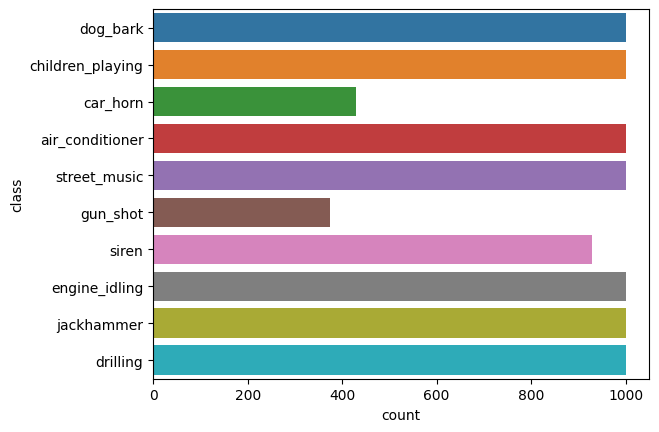

In [97]:
df.groupby('class').fsID.count()

# from https://www.kaggle.com/code/hissain/urbansound8k-beginners
sns.countplot(df, y="class")
plt.show()

We can observe all the classes except **car_horn**, **gun_shot** and **siren** have 1000 samples.

> We could explore options to include class weights in the loss function or oversampling if we see that the under-represented classes are not being classified as well as the rest




In [98]:
# https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook

# Using Librosa to analyse random sound sample - SPECTOGRAM¶

dat1, sampling_rate1 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100263-2-0-117.wav')


In [99]:
#Inspect what is dat1 and sampling_rate1

print(dat1)
print(sampling_rate1)

[-0.00347107 -0.00501926 -0.00465449 ... -0.00248442 -0.00154777
 -0.00035547]
22050


### According to the librosa library, when loading the file we can choose the sampling rate and this is something the Professor talked about when presenting the project.

### Maybe we should use a sampling rate similar accross all sound clips. Check which is the lower possible sampling rate

#### The desired sampling rate can be passed to "librosa.load" as a parameter; default is None

https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load

In [100]:
#Trying to implement a defined sampling rate = 200
dat3, sampling_rate_200 = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav', sr=200)
print(dat3, sampling_rate_200)

[ 1.13929280e-04 -5.22702430e-05 -3.10074174e-05 -5.32484919e-05
  7.51382104e-05 -7.32873159e-05  1.91688188e-04 -8.68833449e-05
 -1.81240874e-04 -5.17905282e-05 -5.34761784e-06  1.02980877e-04
 -1.76618982e-04  1.39857730e-04 -1.04177088e-04 -1.00706573e-04
  1.60455020e-04 -1.89590355e-05 -1.85254714e-04  5.20893809e-06
  3.30988143e-04 -3.93913244e-04 -1.09670276e-04  3.66554770e-04
 -1.24128841e-04 -1.19848402e-04  2.12735089e-04  1.53796173e-05
 -1.73085893e-04  6.57891433e-05  6.31319417e-05  4.62586540e-05
 -2.13150721e-04  2.28308956e-04 -1.28654443e-04  2.51922320e-05
 -6.30366185e-06  1.00873534e-04 -7.29575549e-05 -7.55828878e-05
  1.45595186e-04 -1.85368379e-04  1.66981219e-04 -1.02727499e-04
  1.52770270e-04 -2.44607916e-04  1.53422981e-04 -4.65018238e-05
  6.25358080e-05 -9.66699736e-06 -8.38404958e-07  4.39479263e-05
 -1.63558521e-04  1.76957052e-04 -1.57328628e-04  1.55384885e-04
 -1.26259081e-04  9.65867512e-05 -1.55262125e-04  6.81058445e-05
  1.21777688e-04 -1.68346

## Get audio metadata to understand how the sounds were collected



In [101]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [102]:
#https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb#scrollTo=IUiDNGlGdEAH
# These functions will allow to collect data from the recording framework which can be used as fetures if considered relevant

def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata


def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [103]:
    filepaths = []
    for i, row in df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    df['filepath'] = filepaths

In [104]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,UrbanSound8K/UrbanSound8K/audio/fold5/100032-3...
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,UrbanSound8K/UrbanSound8K/audio/fold5/100263-2...
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,UrbanSound8K/UrbanSound8K/audio/fold7/99812-1-...


In [105]:
# https://mutagen.readthedocs.io/en/latest/api/wave.html
#Checking what kind of data mutagen will extract, to further understand the dataframe
get_audio_metadata_mutagen('UrbanSound8K/UrbanSound8K/audio/fold5/100032-3-0-0.wav')


{'length': 0.31755102040816324,
 'bitrate': 1411200,
 'channels': 2,
 'sample_rate': 44100,
 'bits_per_sample': 16}

**Length** - audio length (seconds)\
**Bitrate** - bit rate (bits / second)\
**Channels** - number of channels used to record the audio (1: mono; 2: stereo)\
**Sample_rate** - sample rate (Hz)\
**Bits_per_sample** - audio sample rate (Hz)\
\
*Some considerations*: This information is important to make decisions regarding the dataset preprocessing. For example: sound clips can have different durations or sampling rates and we need to decide whether this should be a festure.



In [106]:
# include above mentioned data in the df

df = compute_audio_statistics(df)

Columns slice_file: name, fsID, start and end were not considered relevant for the analysis and were removed

In [107]:
# Dropping non-relevant columns
df = df.drop(columns=['slice_file_name', 'fsID', 'start', 'end'])

In [108]:
df.describe()

,salience,fold,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,5.385937,4.592877,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,2.846820,2.894544,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,1.000000,0.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,3.000000,2.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,5.000000,4.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,8.000000,7.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,10.000000,9.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


We can observe in the following tables that the data has been recorded and digitalized in different ways.

It has been mostly recorded using 2 channels in almost all the samples (stereo).
The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
The length of the audios goes from 0.0008s to 4s (mostly 4s)
The bits per sample used go from 4 to 32 (mostly 24 bits)
The data will need to be standardized before to be fed to a machine learning model.

In [109]:
df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                    fold            ... sample_rate           bits_per_sample  \
                   count      mean  ...         75%       max           count   
class                               ...                                         
air_conditioner   1000.0  5.500000  ...     48000.0   48000.0          1000.0   
car_horn           429.0  5.121212  ...     48000.0   96000.0           429.0   
children_playing  1000.0  5.500000  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  5.500000  ...     48000.0   96000.0          1000.0   
drilling          1000.0  5.500000  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.399000  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  5.446524  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  5.062000  ...     48000.0   96000.0          1000.0   
siren              929.0  5.204521  ...     48000.0   48000.0           929.0   
street_music      1000.0  5.500000  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 64 columns]

In [110]:
df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                    fold            ... sample_rate           bits_per_sample  \
                   count      mean  ...         75%       max           count   
class                               ...                                         
air_conditioner   1000.0  5.500000  ...     48000.0   48000.0          1000.0   
car_horn           429.0  5.121212  ...     48000.0   96000.0           429.0   
children_playing  1000.0  5.500000  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  5.500000  ...     48000.0   96000.0          1000.0   
drilling          1000.0  5.500000  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.399000  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  5.446524  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  5.062000  ...     48000.0   96000.0          1000.0   
siren              929.0  5.204521  ...     48000.0   48000.0           929.0   
street_music      1000.0  5.500000  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 64 columns]

In [111]:
from IPython.display import display

In [112]:
#Displaying the whole table

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.groupby('class').describe())

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                    fold                                                \
                   count      mean       std  min  25%  50%  75%   max   
class                                                                    
air_conditioner   1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
car_horn           429.0  5.121212  2.614525  1.0  3.0  5.0  7.0  10.0   
children_playing  1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
dog_bark          1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
drilling          1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   
engine_idling     1000.0  5.399000  2.809215  1.0  3.0  5.0  8.0  10.0   
gun_shot           374.0  5.446524  2.739068  1.0  3.0  6.0  7.0  10.0   
jackhammer        1000.0  5.062000  2.896644  1.0  3.0  5.0  8.0  10.0   
siren              929.0  5.204521  2.802235  1.0  3.0  5.0  8.0  10.0   
street_music      1000.0  5.500000  2.873719  1.0  3.0  5.5  8.0  10.0   

                 classID                                     length            \
                   count mean  std  min  25%  50%  75%  max   count      mean   
class                                                                           
air_conditioner   1000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1000.0  3.994928   
car_horn           429.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   429.0  2.456123   
children_playing  1000.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  1000.0  3.933895   
dog_bark          1000.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  1000.0  3.148281   
drilling          1000.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0  1000.0  3.542295   
engine_idling     1000.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0  1000.0  3.935952   
gun_shot           374.0  6.0  0.0  6.0  6.0  6.0  6.0  6.0   374.0  1.647699   
jackhammer        1000.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0  1000.0  3.609071   
siren              929.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0   929.0  3.910314   
street_music      1000.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0  1000.0  4.000000   

                                                                         \
                       std       min       25%       50%       75%  max   
class                                                                     
air_conditioner   0.093128  2.040000  4.000000  4.000000  4.000000  4.0   
car_horn          1.618848  0.050000  0.738292  3.490000  4.000000  4.0   
children_playing  0.424658  0.008073  4.000000  4.000000  4.000000  4.0   
dog_bark          1.331572  0.119819  2.040000  4.000000  4.000000  4.0   
drilling          1.013475  0.007937  4.000000  4.000000  4.000000  4.0   
engine_idling     0.370909  0.766553  4.000000  4.000000  4.000000  4.0   
gun_shot          0.902516  0.166281  1.009195  1.472698  2.185255  4.0   
jackhammer        0.891129  0.000816  4.000000  4.000000  4.000000  4.0   
siren             0.502674  0.260000  4.000000  4.000000  4.000000  4.0   
street_music      0.000000  4.000000  4.000000  4.000000  4.000000  4.0   

                 bitrate                                     

Data Visualization\
As the data consists of Audio files we will use the Librosa library to load, plot and perform audio processing.




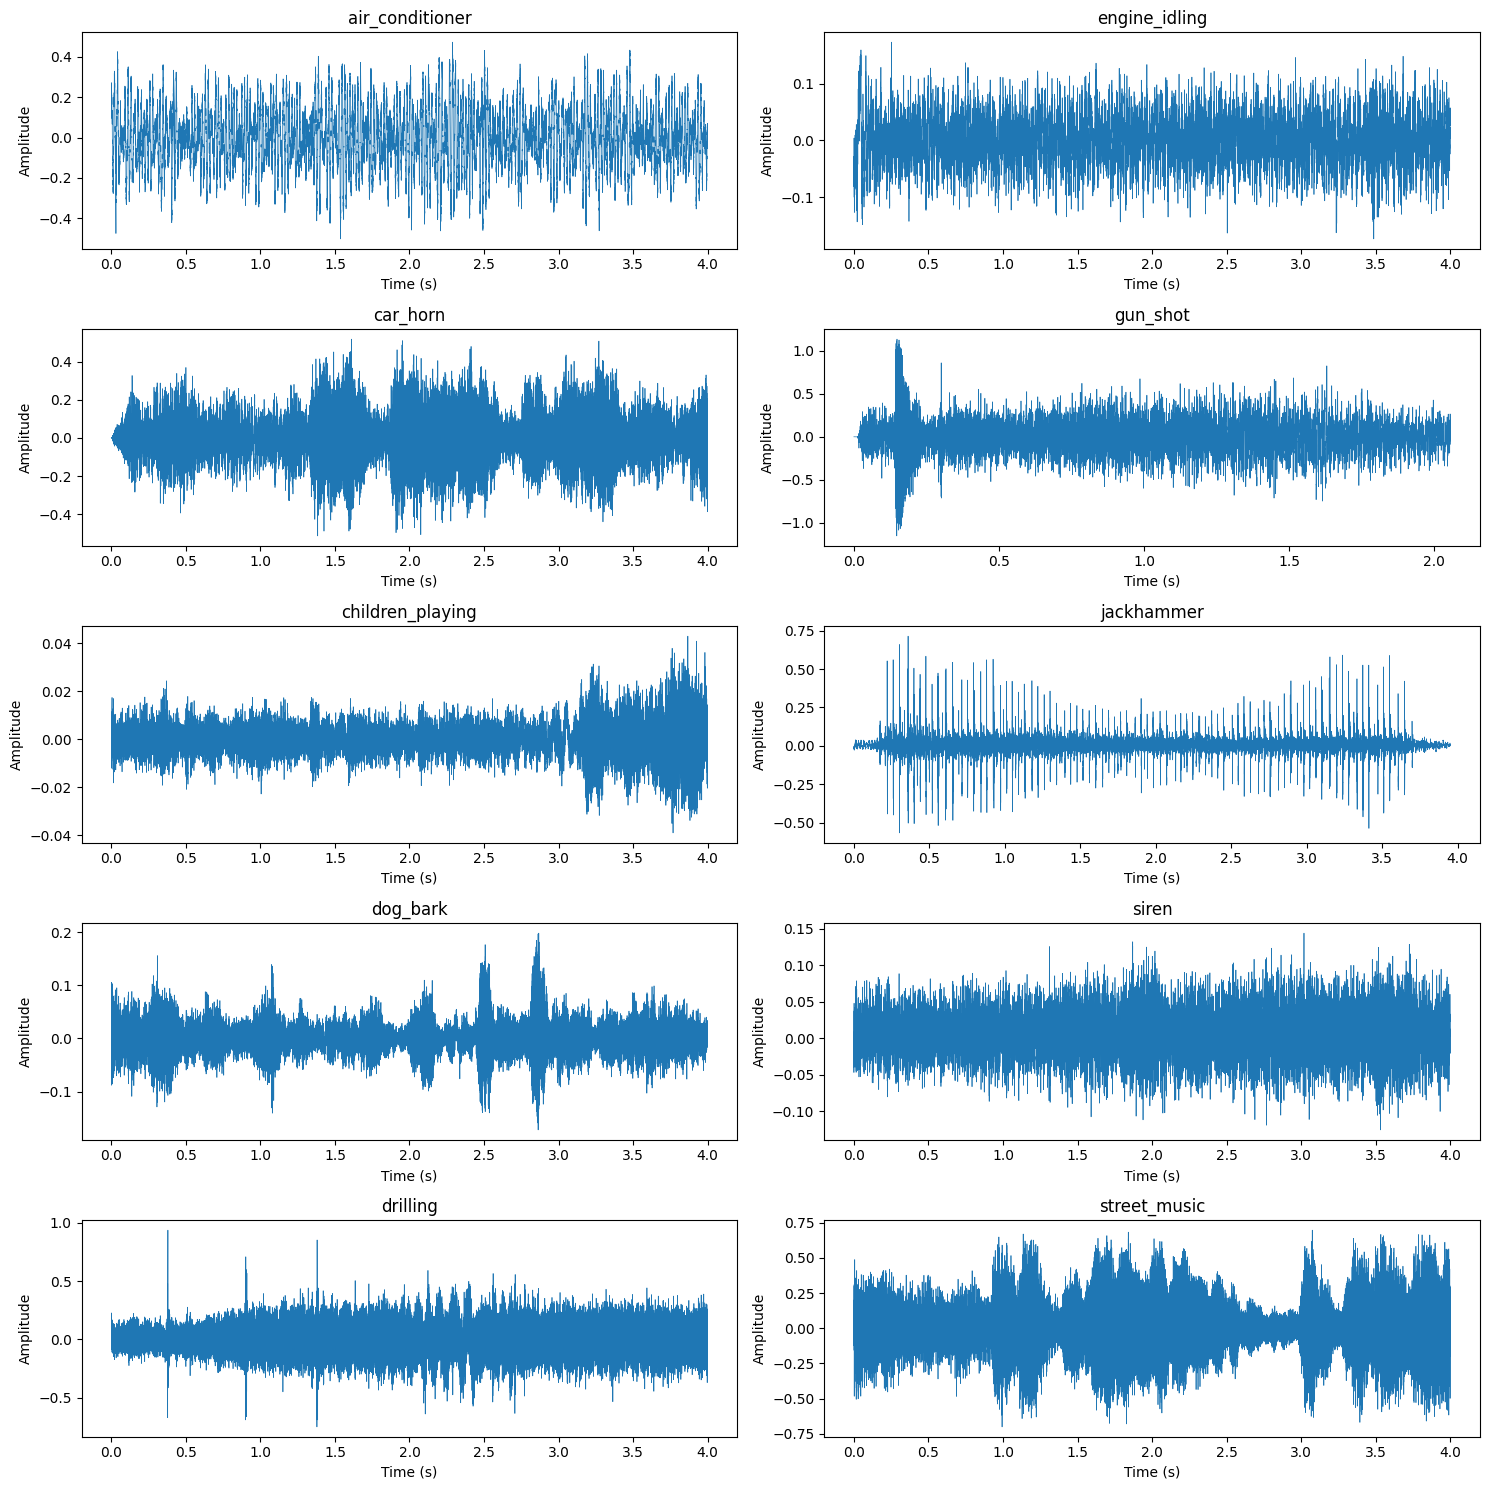

In [113]:
import matplotlib.pyplot as plt
import librosa.display

# Randomly select one sample of each class
random_samples = df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        duration = librosa.get_duration(y=audio_file, sr=sample_rate)
        time = librosa.samples_to_time(range(len(audio_file)), sr=sample_rate)

        axs[row][col].plot(time, audio_file, linewidth=0.5)
        axs[row][col].set_title('{}'.format(labels[index]))
        axs[row][col].set_xlabel('Time (s)')
        axs[row][col].set_ylabel('Amplitude')

        index += 1

fig.tight_layout()
plt.show()


STFT (Short-Term Fourier Transform), Mel-Spectograms and MFCC (Mel-Frequency Cepstral Coefficients) are all popular ways to process audio signals and generate features as input for machine learning algorithms such as Convolutional Neural Networks.

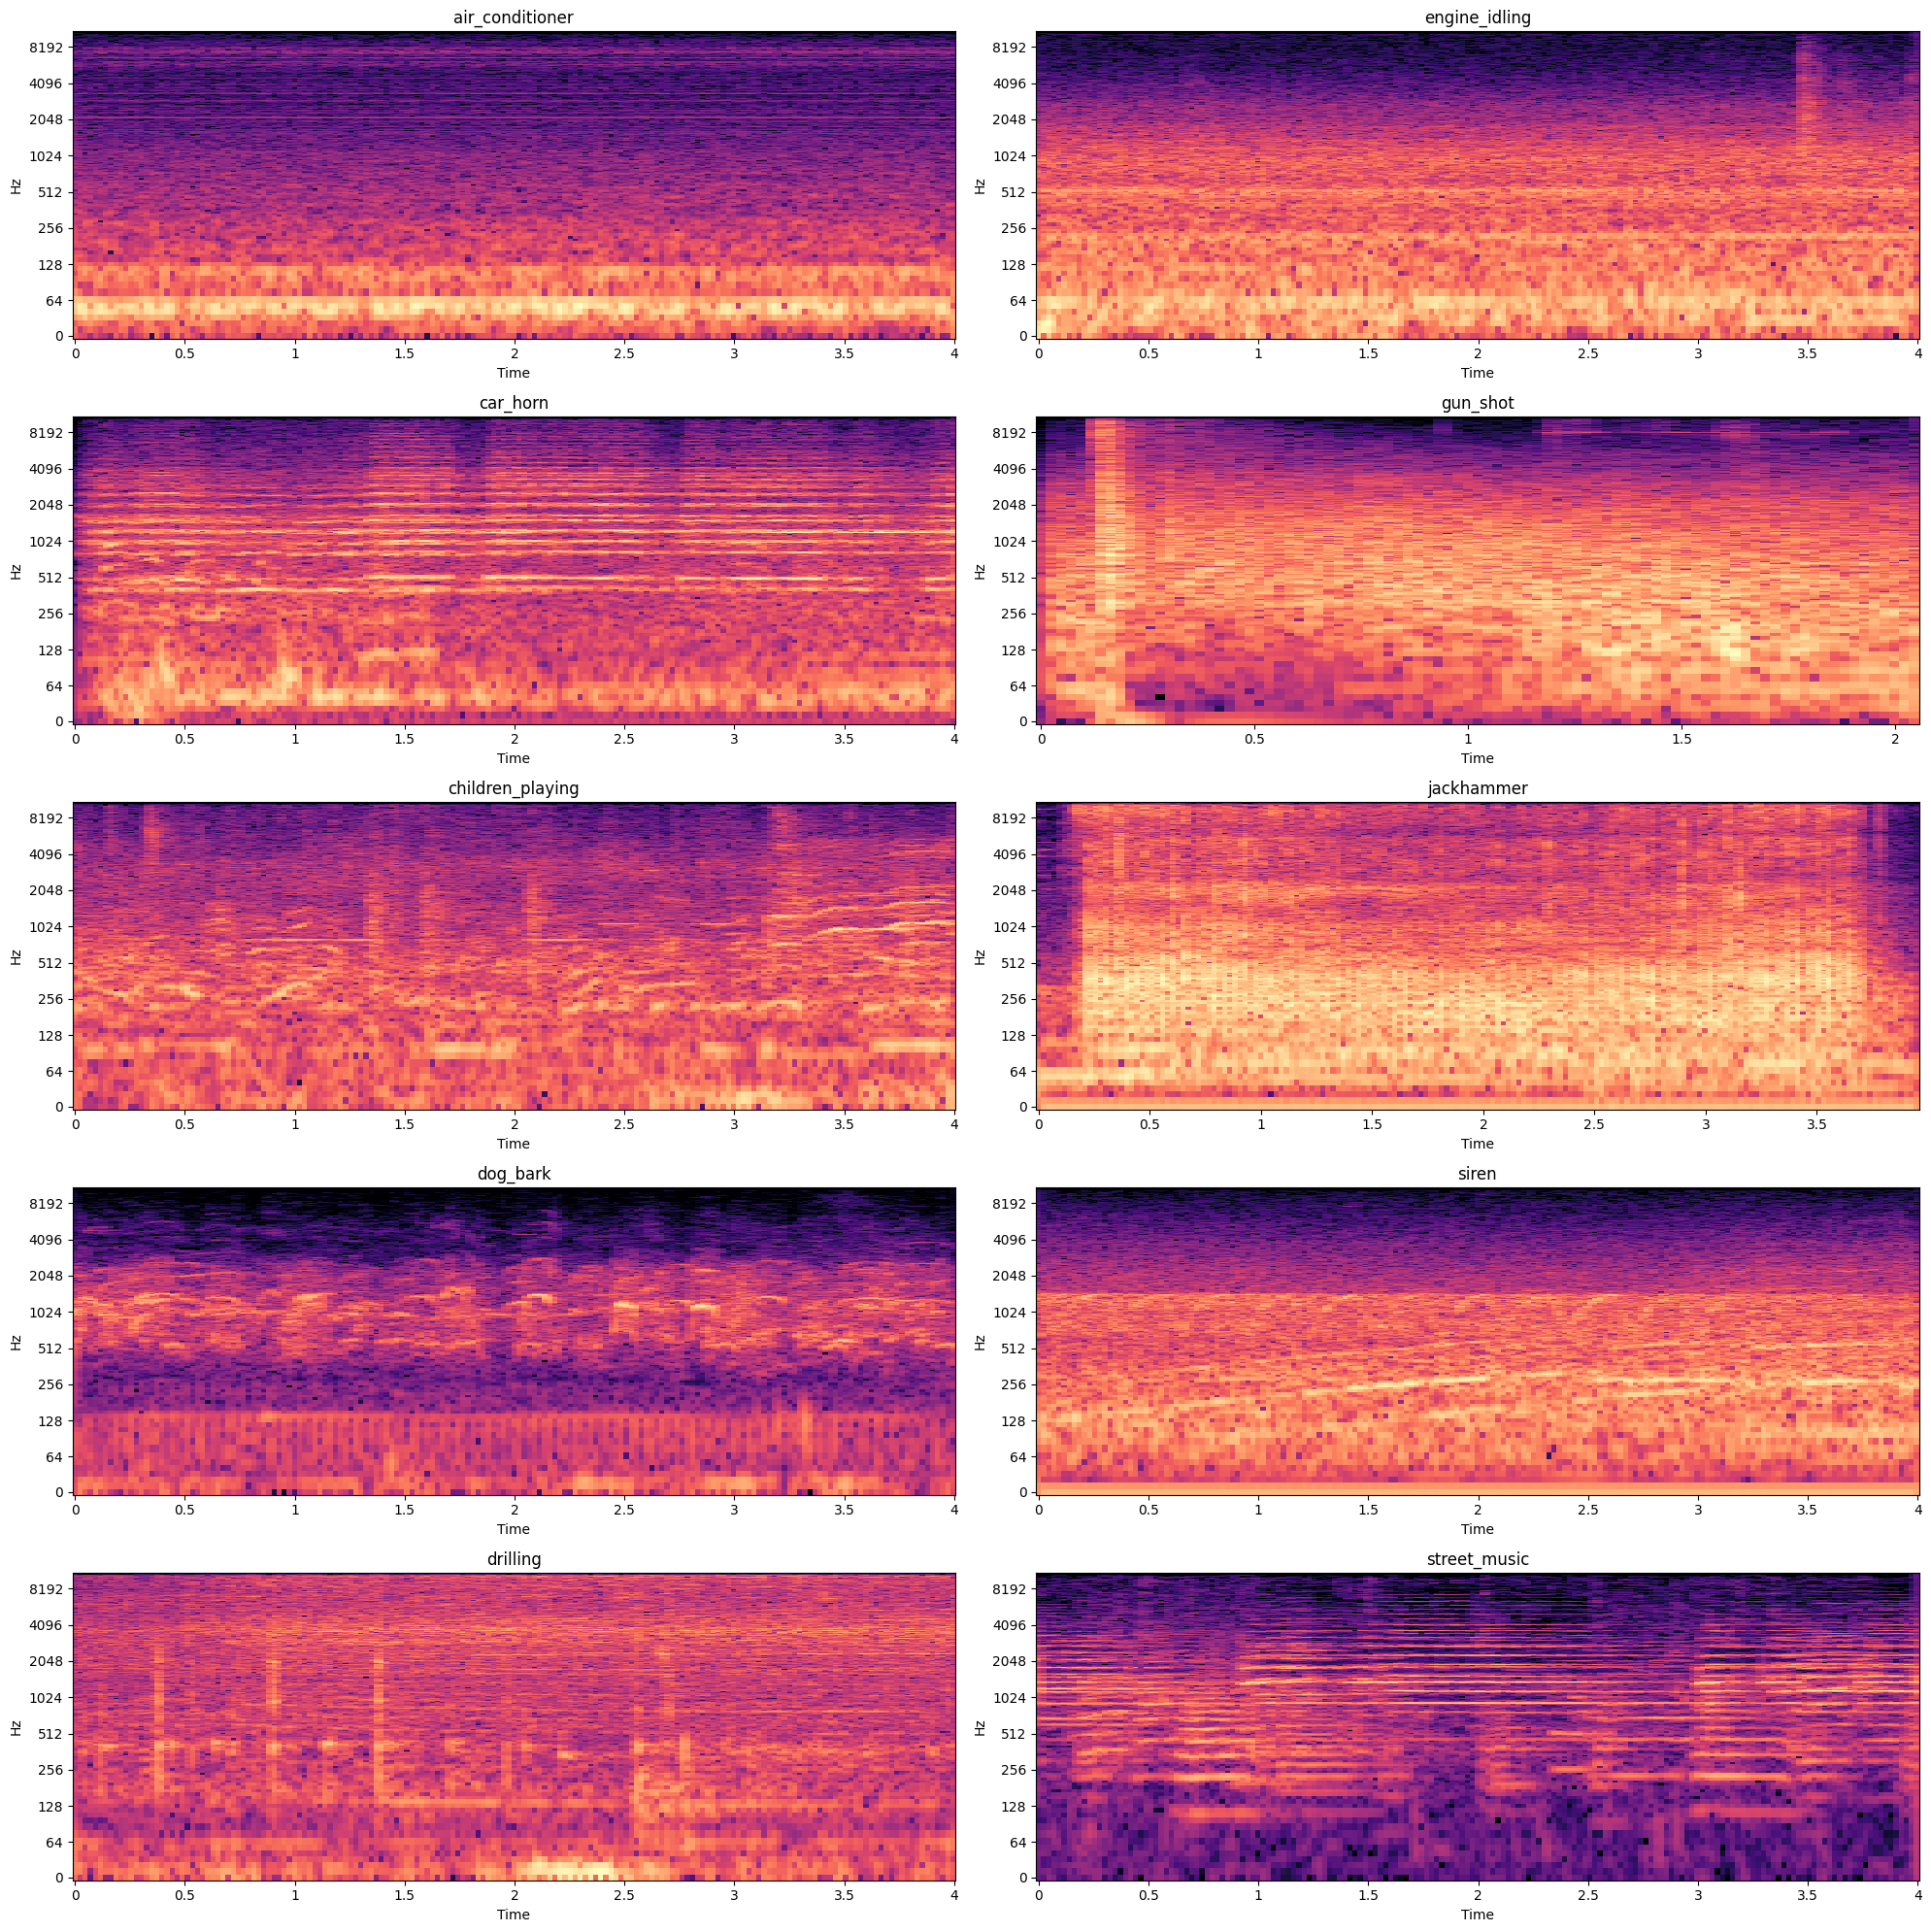

In [114]:

import numpy as np

# Visualize the STFT
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()

Next we will visualize the Mel-Spectogram which is a representation of the different frequencies magnitudes at different timesteps. The frequency magnitude is transformed to be on the Mel Scale, that takes into account how humans perceive and process audio signals.


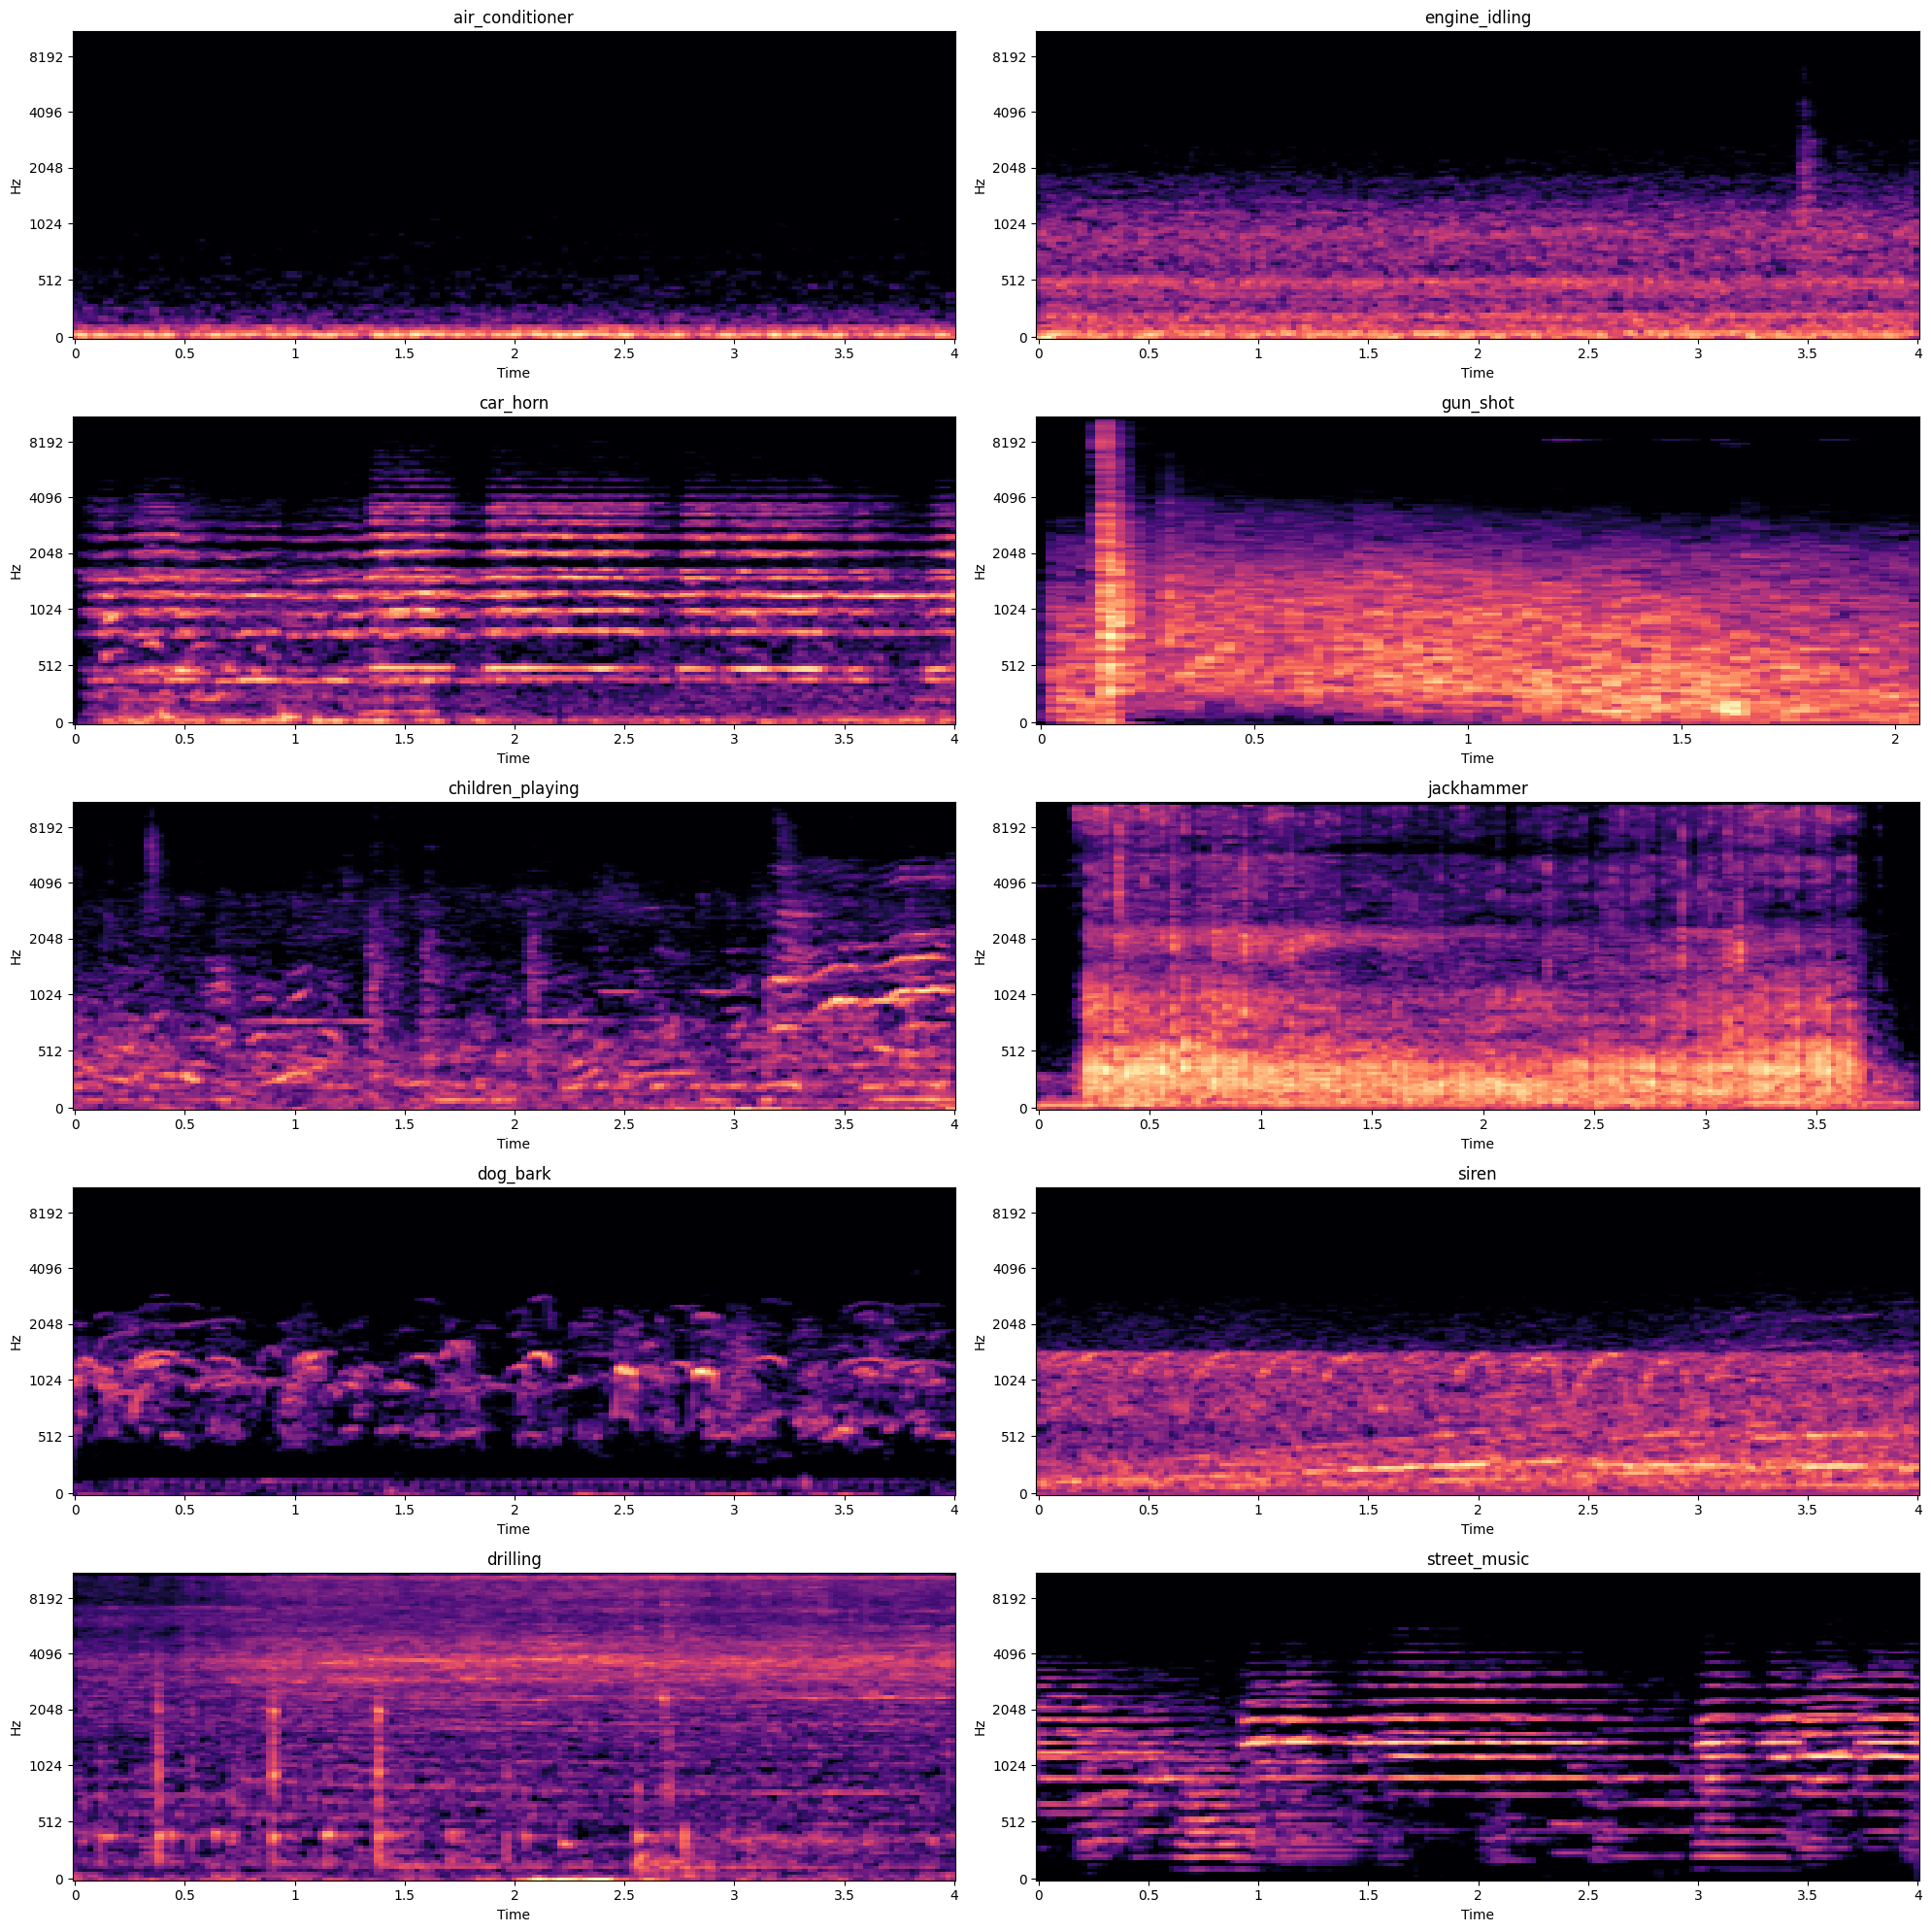

In [115]:
# Visualize the Mel-Spectrograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mel_spec = librosa.feature.melspectrogram(y=audio_file, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(S_db,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()

## From here:
 https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

 #### After looking into the functions, it doesn't seem like I can handle this.

In [116]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

Convert to two channels\
Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). Since our model expects all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second.

In [124]:
 """# ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
    def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])

      return ((resig, sr))"""

'# ----------------------------\n # Convert the given audio to the desired number of channels\n # ----------------------------\n @staticmethod\n   def rechannel(aud, new_channel):\n     sig, sr = aud\n\n     if (sig.shape[0] == new_channel):\n       # Nothing to do\n       return aud\n\n     if (new_channel == 1):\n       # Convert from stereo to mono by selecting only the first channel\n       resig = sig[:1, :]\n     else:\n       # Convert from mono to stereo by duplicating the first channel\n       resig = torch.cat([sig, sig])\n\n     return ((resig, sr))'

Standardize sampling rate\
Some of the sound files are sampled at a sample rate of 48000Hz, while most are sampled at a rate of 44100Hz. This means that 1 second of audio will have an array size of 48000 for some sound files, while it will have a smaller array size of 44100 for the others. Once again, we must standardize and convert all audio to the same sampling rate so that all arrays have the same dimensions.

In [125]:
 """ # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))"""

' # ----------------------------\n # Since Resample applies to a single channel, we resample one channel at a time\n # ----------------------------\n @staticmethod\n def resample(aud, newsr):\n   sig, sr = aud\n\n   if (sr == newsr):\n     # Nothing to do\n     return aud\n\n   num_channels = sig.shape[0]\n   # Resample first channel\n   resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])\n   if (num_channels > 1):\n     # Resample the second channel and merge both channels\n     retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])\n     resig = torch.cat([resig, retwo])\n\n   return ((resig, newsr))'

Resize to the same length\
We then resize all the audio samples to have the same length by either extending its duration by padding it with silence, or by truncating it. We add that method to our AudioUtil class.

In [126]:

 """ # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)"""

" # ----------------------------\n # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds\n # ----------------------------\n @staticmethod\n def pad_trunc(aud, max_ms):\n   sig, sr = aud\n   num_rows, sig_len = sig.shape\n   max_len = sr//1000 * max_ms\n\n   if (sig_len > max_len):\n     # Truncate the signal to the given length\n     sig = sig[:,:max_len]\n\n   elif (sig_len < max_len):\n     # Length of padding to add at the beginning and end of the signal\n     pad_begin_len = random.randint(0, max_len - sig_len)\n     pad_end_len = max_len - sig_len - pad_begin_len\n\n     # Pad with 0s\n     pad_begin = torch.zeros((num_rows, pad_begin_len))\n     pad_end = torch.zeros((num_rows, pad_end_len))\n\n     sig = torch.cat((pad_begin, sig, pad_end), 1)\n     \n   return (sig, sr)"

## From feature_extraction_example.ypnb provided by the Professor

In [132]:
# Find all wav file in dir

_wav_dir_="UrbanSound8K/UrbanSound8K/audio/fold10/"
files = librosa.util.find_files(_wav_dir_)

In [133]:
# PARAMETERS
# resampling freq
target_sr =44100

# MFCC parameters
n_mfcc=40
hop_length=round(target_sr*0.0125)
win_length=round(target_sr*0.023)
n_fft=2**14
mfcc_time_size = 4*target_sr//hop_length+1

# read all wav file without resampling
dataset=np.zeros(shape=[len(files),4*target_sr])
dataset_mfcc=np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])

In [134]:
i=0
for f in files:
    (sig, rate) = librosa.load(f, sr=None)
    sig_res =librosa.resample(sig, orig_sr=rate, target_sr=target_sr)
    # zero padding
    if len(sig_res)<4*target_sr:
        sig_res_pad = np.concatenate((sig_res, np.zeros(4*target_sr-len(sig_res))),axis=0)
    else:
        sig_res_pad=sig_res
    dataset[i]=sig_res_pad
    # computes the MFCCs
    sig_mfcc =librosa.feature.mfcc(y=sig_res_pad,sr=target_sr,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
    dataset_mfcc[i]=sig_mfcc
    i+=1

In [135]:
print(dataset)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.07116699e-02  1.09252930e-02  8.57543945e-03 ...  1.28784180e-02
  -6.10351562e-05 -1.49536133e-03]
 [ 2.43225098e-02  1.17492676e-02  2.40478516e-02 ... -7.33032227e-02
  -1.30798340e-01 -9.21630859e-02]
 [ 3.46679688e-02  1.86157227e-02  6.04248047e-03 ... -4.40979004e-02
  -3.72314453e-02 -2.90832520e-02]]


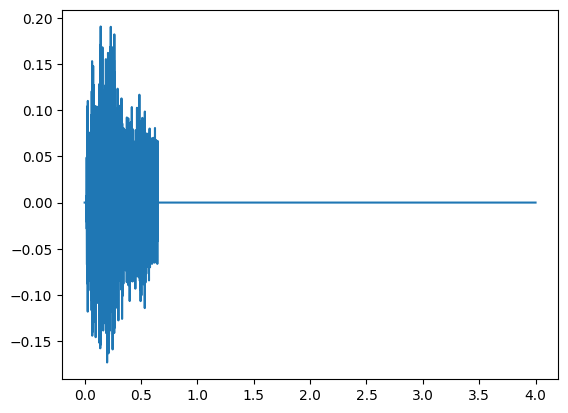

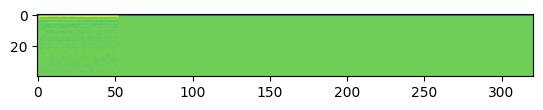

In [136]:
# Visualization of an example
index=0
plt.figure()
plt.plot(np.asarray(list(range(4*target_sr)))/target_sr,dataset[index])
plt.show()

plt.figure()
plt.imshow(dataset_mfcc[index])
plt.show()


https://www.kaggle.com/code/sachinsarkar/urban-sound-classification-usnig-librosa-and-ann **MFCC**\
https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification **MEL Spectogram**\
https://colab.research.google.com/github/jsalbert/sound_classification_ml_production/blob/main/notebooks/UrbanSound8k_data_exploration.ipynb?pli=1#scrollTo=YWDyO8Ik09AS **bom p/ outras coisas, não tem feat extraction**\
https://www.kaggle.com/code/sreevaatsavbavana/sound-classifiaction-using-ml-and-deep-learning#Extracting-features-from-Audio-data **extracts all librosa features**\
https://www.kaggle.com/code/susant4learning/urbansound8k-dataprep-model **MFCC**\
https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook#Feature-Extraction-and-Database-Building **Mel Spectrogram**\
**Librosa library** https://librosa.org/doc/latest/feature.html\
https://www.kaggle.com/code/furkannakdagg/urban-sound-classification#Hyperparameter-Optimization **cnn and hyperparameter tuning**\
https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV **DataSet Source**

